In [1]:
from google.colab import drive
drive.mount('/content/drive')
# import os
# os.makedirs('/content/drive/MyDrive/sentiment_project', exist_ok=True)

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/drive/MyDrive/sentiment_project/processed_reviews_50k.csv')

In [4]:
df.info()
df.describe()
df.shape
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49962 entries, 0 to 49961
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             49962 non-null  float64
 1   title              49962 non-null  object 
 2   text               49962 non-null  object 
 3   timestamp          49962 non-null  int64  
 4   helpful_vote       49962 non-null  int64  
 5   verified_purchase  49962 non-null  int64  
 6   label              49962 non-null  object 
 7   full_text          49962 non-null  object 
 8   sentiment          49962 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 3.4+ MB


,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text,sentiment
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware,negative
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...,positive
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...,positive
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games,positive
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...,positive


In [6]:
print(df[['full_text', 'sentiment']].isna().sum())

full_text    0
sentiment    0
dtype: int64


In [7]:
df.head()

,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text,sentiment
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware,negative
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...,positive
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...,positive
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games,positive
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...,positive


In [8]:
X_text = df['full_text']
X_extra = df[['verified_purchase', 'helpful_vote']]
y = df['sentiment']

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

***Vectorization TF-IDF Selection par chi*** **2**

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test) # une transformation en se basant sur le vocabulaire appris du train not the new words in the test set

In [11]:
# selection des 'features' avec chi 2
from sklearn.feature_selection import SelectKBest, chi2

# le fit : sélectionner les 300 features avec les scores chi² les plus élevés
# le transform :  supprimer toutes les cfeatures qui ne font pas partie des 300 retenues
selector = SelectKBest(score_func=chi2, k=300)
X_train_selected = selector.fit_transform(X_train_vec, y_train)

X_test_selected = selector.transform(X_test_vec)

In [12]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time

print("Model: LinearSVC with Class Weight Balancing")

target_names = ['negative', 'neutral', 'positive']


svm_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=5000)

start_time = time.time()
svm_model.fit(X_train_selected, y_train)
train_time = time.time() - start_time

print(f"Training took {train_time/60:.2f} minutes")

y_pred_svm = svm_model.predict(X_test_selected)

acc = accuracy_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svm, target_names=target_names)}")

# Cross-validation (5 folds)
cv_scores = cross_val_score(svm_model, X_train_selected, y_train, cv=StratifiedKFold(5), scoring='f1_macro', n_jobs=-1)
print("Cross-validation (5 folds) on training data:")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Model: LinearSVC with Class Weight Balancing
Training took 0.01 minutes
Accuracy: 0.8219
F1 Score (macro): 0.7231
Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.77      0.76      2321
     neutral       0.63      0.44      0.52      1244
    positive       0.88      0.91      0.89      6428

    accuracy                           0.82      9993
   macro avg       0.75      0.71      0.72      9993
weighted avg       0.81      0.82      0.82      9993

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.7213 (+/- 0.0069)


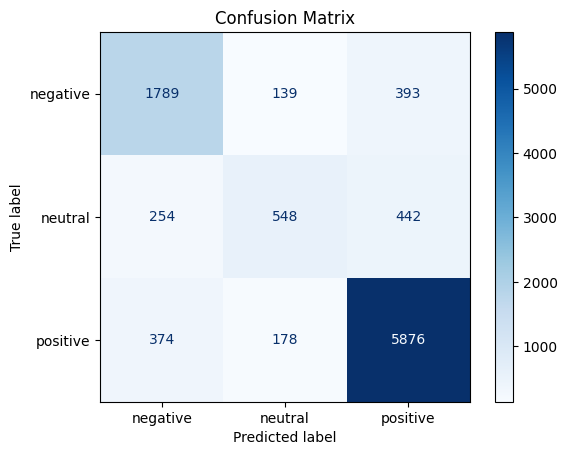

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [14]:
import joblib
joblib.dump(svm_model, '/content/drive/MyDrive/sentiment_project/svm_model_bert_chi2.joblib')

['/content/drive/MyDrive/sentiment_project/svm_model_bert_chi2.joblib']

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time

print("Model: Logistic Regression with Class Weight Balancing")

# Define class labels (ensure same order as LabelEncoder)
target_names = ['negative', 'neutral', 'positive']

# Create model with solver optimized for large datasets
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    solver='saga',          # Good for large data + supports L1/L2 penalties
    n_jobs=-1               # Use all cores during fitting
)

# Train model and track training time
start_time = time.time()
lr_model.fit(X_train_selected, y_train)
train_time = time.time() - start_time
print(f"Training took {train_time / 60:.2f} minutes")

# Predict
y_pred_lr = lr_model.predict(X_test_selected)

# Evaluation
acc = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_lr, target_names=target_names)}")

# Cross-validation (parallelized)
cv_scores = cross_val_score(
    lr_model,
    X_train_selected,
    y_train,
    cv=StratifiedKFold(5),
    scoring='f1_macro',
    n_jobs=-1
)
print("Cross-validation (5 folds) on training data:")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Model: Logistic Regression with Class Weight Balancing
Training took 0.01 minutes
Accuracy: 0.7644
F1 Score (macro): 0.6921
Classification Report:
              precision    recall  f1-score   support

    negative       0.66      0.84      0.74      2321
     neutral       0.42      0.60      0.49      1244
    positive       0.94      0.77      0.85      6428

    accuracy                           0.76      9993
   macro avg       0.67      0.73      0.69      9993
weighted avg       0.81      0.76      0.78      9993

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6908 (+/- 0.0045)


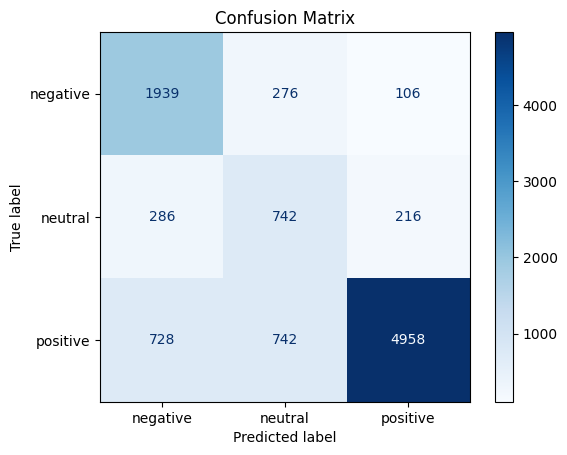

In [16]:
cm2 = confusion_matrix(y_test, y_pred_lr)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [17]:
joblib.dump(lr_model, '/content/drive/MyDrive/sentiment_project/lr_model_bert_chi2.joblib')

['/content/drive/MyDrive/sentiment_project/lr_model_bert_chi2.joblib']